In [1]:
import os
from pathlib import Path
import sys
import rasterio
import torch
import torch.nn as nn
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Read in label datframe

In [2]:
# load dataframe of labels
path = "../data/filtered_labels.geojson"
label_df = gpd.read_file(path)

In [3]:
# load image directory
data_path="/n/holyscratch01/tambe_lab/kayan/karena/images/"

In [4]:
# remove rows from dataframe without corresponding images
dir_ids = [Path(file_name).stem for file_name in os.listdir(data_path)]
label_df = label_df[label_df["unique_id"].isin(dir_ids)]

In [5]:
print(f"Number of samples (all): {len(label_df)}")

Number of samples (all): 14641


In [6]:
# look at distribution of samples across confidence ratings
label_df.groupby("confidence").size()

confidence
3.000000    2183
3.333333      25
3.500000     308
3.666667       1
3.666667      37
4.000000    3829
4.250000       2
4.333333      94
4.500000     441
4.666667     128
4.750000       6
5.000000    7587
dtype: int64

# Plot examples

In [7]:
data_path="/n/holyscratch01/tambe_lab/kayan/karena/"

In [8]:
def load_img(img_id):
    img_path = data_path+"images/"+img_id+".tif"
    img = rasterio.open(img_path)
    img = img.read([3,2,1]) #RGB channels
    
    # normalize per channel
    img_norm = (img.T - np.min(img,axis=(1,2))) / (np.max(img,axis=(1,2)) - np.min(img,axis=(1,2))) # we take the transpose to allow for broadcasting
    img_norm = img_norm.T # undo transpose
    return img_norm

def load_raster(raster_id):
    raster_path = data_path+"rasters/"+raster_id+".tif"
    raster = rasterio.open(raster_path)
    raster = raster.read([1])
    return raster

In [42]:
def plot_single(i):
    img = load_img(i)
    raster = load_raster(i)

    plt.subplot(121)
    plt.imshow(np.moveaxis(img,0,-1))
    plt.title("Input image")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(np.moveaxis(raster,0,-1),cmap="gray")
    plt.title("Ground truth label")
    plt.axis("off");
    plt.tight_layout()

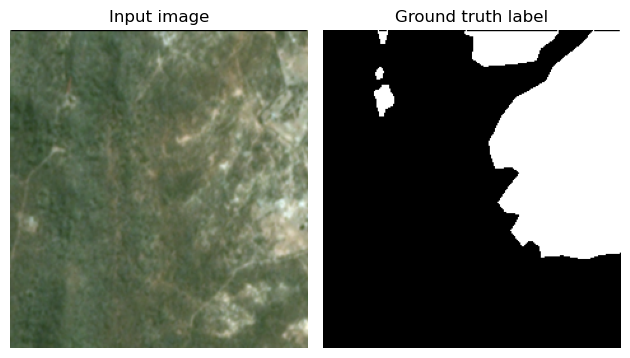

In [43]:
# mine with confidence 3
plot_single("lat_-20--415__lon_30--135")

In [9]:
# identify some sample IDs with mine + confidence rating 3
label_df[(label_df["confidence"]==3) & (label_df["label"]==1.0)].sort_values("area_km2", ascending=False).head()

,lon,lat,unique_id,country,province,input_id,sample_type,mine_type,confidence,label,area_km2,proportion_inspected,proportion_mining,assumed_label,2_cell_buffer,3_cell_buffer,4_cell_buffer,5_cell_buffer,geometry
2028,27.405,-7.545,lat_-7--545__lon_27--405,COD,Haut-Lomami,DRC-1096CL,IPIS,artisanal,3.0,1.0,0.976984,0.633750,0.781573,positive,True,True,True,True,"POLYGON ((27.40000 -7.54412, 27.40000 -7.54271..."
2811,28.865,-4.165,lat_-4--165__lon_28--865,COD,Sud-Kivu,DRC-2258CL,IPIS,artisanal,3.0,1.0,0.610492,0.787254,0.491347,positive,True,True,True,True,"MULTIPOLYGON (((28.86897 -4.16976, 28.86877 -4..."
1737,26.545,-2.645,lat_-2--645__lon_26--545,COD,Maniema,DRC-452CL,IPIS,artisanal,3.0,1.0,0.479409,0.565030,0.386457,positive,True,True,True,True,"POLYGON ((26.54651 -2.64166, 26.54664 -2.64211..."
3129,29.955,-19.995,lat_-19--995__lon_29--955,ZWE,Midlands,Zimbabwe-146CL,IPIS,artisanal,3.0,1.0,0.369141,0.724900,0.279929,positive,True,True,True,True,"MULTIPOLYGON (((29.95023 -19.99991, 29.95020 -..."
3236,30.135,-20.415,lat_-20--415__lon_30--135,ZWE,Midlands,Zimbabwe-22CL,IPIS,artisanal,3.0,1.0,0.348085,0.510413,0.263254,positive,True,True,True,True,"MULTIPOLYGON (((30.13802 -20.41707, 30.13734 -..."


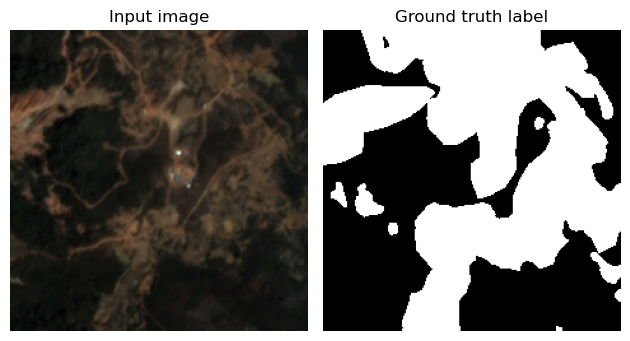

In [44]:
# mine with confidence 5
plot_single("lat_8--585__lon_-11--155")

In [10]:
# identify some sample IDs with mine + confidence rating 5
label_df[(label_df["confidence"]==5) & (label_df["label"]==1.0)].sort_values("area_km2", ascending=False).head()

,lon,lat,unique_id,country,province,input_id,sample_type,mine_type,confidence,label,area_km2,proportion_inspected,proportion_mining,assumed_label,2_cell_buffer,3_cell_buffer,4_cell_buffer,5_cell_buffer,geometry
830,-11.155,8.585,lat_8--585__lon_-11--155,SLE,Eastern,SLE-47CL,IPIS,artisanal,5.0,1.0,0.616254,0.947566,0.491726,positive,True,True,True,True,"MULTIPOLYGON (((-11.15781 8.58335, -11.15775 8..."
2155,27.835,-3.375,lat_-3--375__lon_27--835,COD,Sud-Kivu,DRC-1149CL,IPIS,artisanal,5.0,1.0,0.521179,0.396385,0.419847,positive,True,True,True,True,"POLYGON ((27.83941 -3.37063, 27.83930 -3.37087..."
906,-11.105,8.605,lat_8--605__lon_-11--105,SLE,Eastern,SLE-700CL,IPIS,artisanal,5.0,1.0,0.511703,0.881124,0.408279,positive,True,True,True,True,"MULTIPOLYGON (((-11.10881 8.60146, -11.10884 8..."
312,-11.705,8.565,lat_8--565__lon_-11--705,SLE,Northern,SLE-639CL,IPIS,artisanal,5.0,1.0,0.456787,0.989498,0.364503,positive,True,True,True,True,"MULTIPOLYGON (((-11.70706 8.56000, -11.70705 8..."
2058,27.455,-7.275,lat_-7--275__lon_27--455,COD,Tanganyika,DRC-273CL,IPIS,artisanal,5.0,1.0,0.447247,0.969766,0.358010,positive,True,True,True,True,"MULTIPOLYGON (((27.45308 -7.27655, 27.45326 -7..."
